In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
import matplotlib.pyplot as plt
!pip install pmdarima

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data importation

In [ ]:
df=pd.read_csv("predicted_sentiment.csv")
backup=df.copy()

In [ ]:
df.head()

,Unnamed: 0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,sentiment
0,0,0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]","came time veru happi it, use alreay make takig...",5,Woks very good,1390694400,"01 26, 2014",Sports and outdoors,3
1,1,1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]","ha factori glock tool usig glock 26, 27, 17 i...",5,Works as well as the factory tool,1328140800,"02 2, 2012",Sports and outdoors,4
2,2,2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]","o't 3/32 puch woul like oe glock bag, okay bu...",4,"It's a punch, that's all.",1330387200,"02 28, 2012",Sports and outdoors,3
3,3,3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",work better tha ay 3/32 puch woul fi harar sto...,4,It's a punch with a Glock logo.,1328400000,"02 5, 2012",Sports and outdoors,3
4,4,4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",purchas thikig mayb ee special tool easili pop...,4,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013",Sports and outdoors,4


# Time series forecasting for Electronic ear muffs

In [ ]:
df=df[df["category"]=="Sports and outdoors"]

In [ ]:
df["category"].unique()

array(['Sports and outdoors'], dtype=object)

In [ ]:
df=df[df["asin"]=="B001T7QJ9O"]

Time Series

In [ ]:
df.drop(["overall","unixReviewTime", "Unnamed: 0"], inplace= True, axis = 1)

In [ ]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])
df = df.set_index('reviewTime')

In [ ]:
df = df.resample("Q").mean()

C:\Users\AR\AppData\Local\Temp\ipykernel_27156\810814496.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample("Q").mean()


In [ ]:
# df=df.iloc[2:,:]

# Decomposition of data 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(df['sentiment'],period=4)
d_trend=decomposition.trend
d_seasonality=decomposition.seasonal
d_residual=decomposition.resid

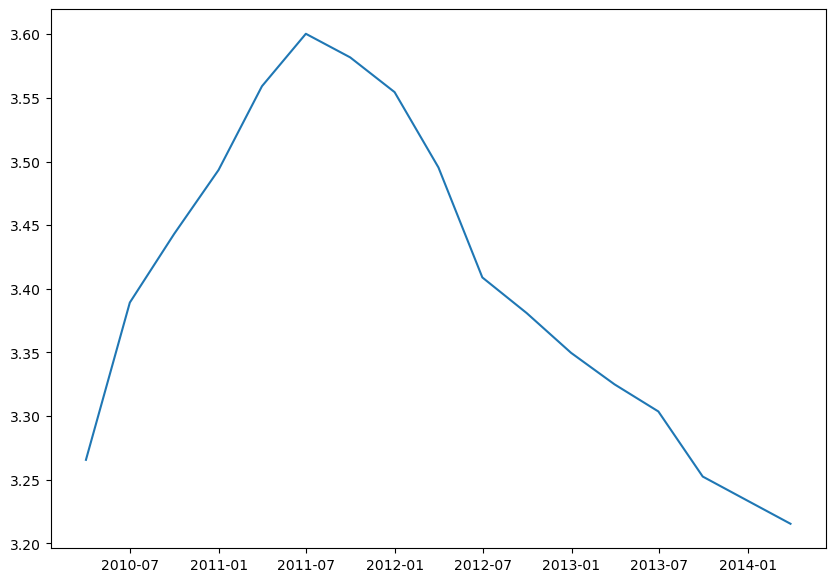

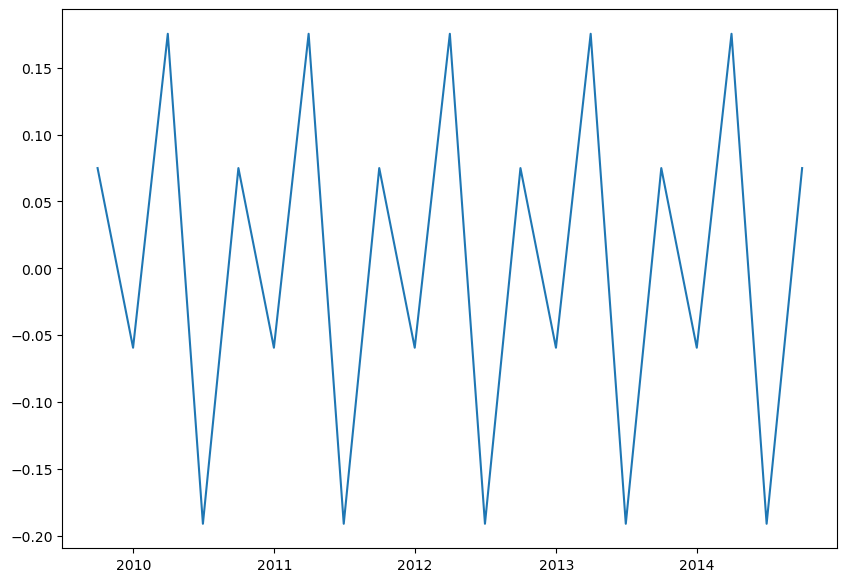

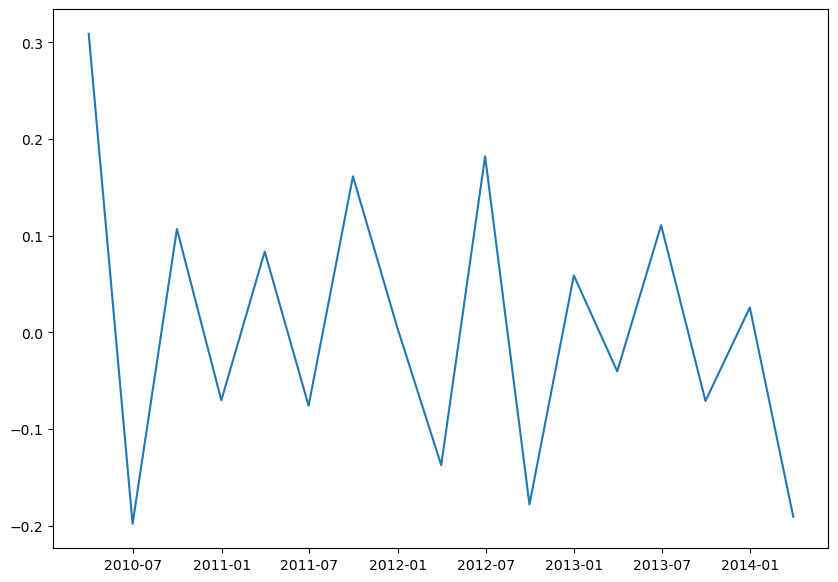

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(d_trend)
plt.figure(figsize=(10,7))
plt.plot(d_seasonality)
plt.figure(figsize=(10,7))
plt.plot(d_residual)
plt.show()

We can see from the above cahrts that the data has all 3 components trend seasonality and noise

### Checking Stationarity

In [ ]:
df = df['sentiment']

In [ ]:
# dickey-fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
def checkStationarity(df):
    pvalue = adfuller(df)[1]
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)
checkStationarity(df)

'p-value=0.9923250376895935. Data is not stationary'

According to Adfuller data is not stationary and thus needs to be differenced

In [ ]:
df=df.rolling(window=2).mean()          
df.dropna(inplace=True)

# Using Autoarima to find optimal parameters 

In [ ]:
from pmdarima.arima import auto_arima
df_new = auto_arima(df,start_p=0,max_p=2, start_q=0,max_q=2, seasonal=True, trace=True)
print(df_new.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-11.945, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-23.089, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-20.001, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=107.425, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-21.128, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-21.262, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-20.034, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.555 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  14.544
Date:                Tue, 03 Jan 2023   AIC                            -23.089
Time:                        12:02:22   BIC     

Auto arima gives us an optimal p,d,q values of (0,1,0) value

# Building sarima model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [ ]:
train = df.iloc[:15]
test = df.iloc[15:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 15, test = 5


In [ ]:
import statsmodels.api

In [ ]:
p=1; d=0; q=0
model = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(1,d,q,4)).fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         sentiment   No. Observations:                   15
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood                   6.069
Date:                           Tue, 03 Jan 2023   AIC                             -6.139
Time:                                   12:02:22   BIC                             -4.014
Sample:                               12-31-2009   HQIC                            -6.161
                                    - 06-30-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.022     45.673      0.000       0.956       1.041
ar.S.L4        0.2664      0.564      0.472

C:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [ ]:
start = len(train)
stop = len(train)+len(test)-1

In [ ]:
predictions = model.predict(start,stop,dynamic=True)
print( predictions)

2013-09-30    3.303749
2013-12-31    3.293013
2014-03-31    3.313320
2014-06-30    3.292623
2014-09-30    3.278545
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [ ]:
df_res = pd.DataFrame({'actual':df[9:],'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
df_res.dropna(inplace=True)
print(df_res)

              actual  predicted       err
2013-09-30  3.239970   3.303749 -0.063779
2013-12-31  3.228205   3.293013 -0.064808
2014-03-31  3.200000   3.313320 -0.113320
2014-06-30  3.266667   3.292623 -0.025957
2014-09-30  3.166667   3.278545 -0.111879


In [ ]:
msg = 'ARMA Model. Order=(' + str(0) + ',' + str(0) + ')'
mse1 = mean_squared_error(test,predictions )
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(0,0)
	MSE = 0.006859990445263681
	RMSE = 0.08282505928318845


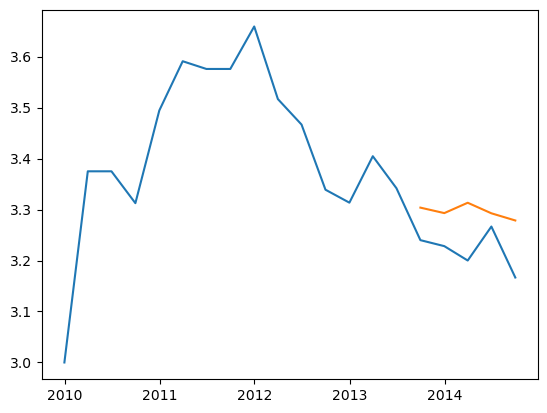

In [ ]:
plt.plot(df)
plt.plot(predictions)

We can see that the sarima model closely follows the data trend

# Prediction for trends after 2014

In [ ]:
model = sm.tsa.statespace.SARIMAX(df,order=(p,d,q),seasonal_order=(1,d,q,4)).fit()

C:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [ ]:
forecast=model.forecast(10)

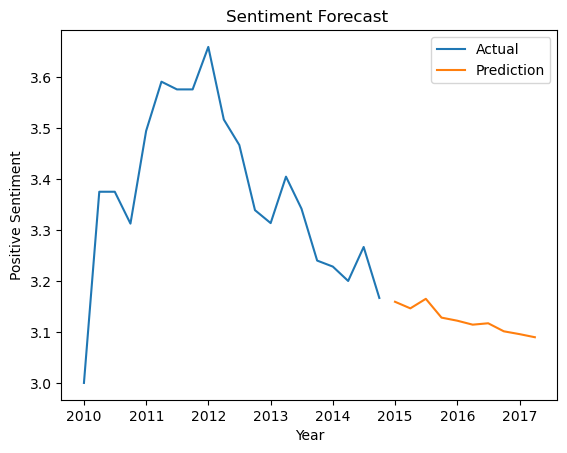

In [ ]:
plt.title("Sentiment Forecast ")
plt.plot(df)
plt.xlabel("Year")
plt.ylabel("Positive Sentiment")
plt.plot(forecast)
plt.legend(['Actual','Prediction'])
plt.show()


# Time series forecasting for Mag loader 

In [ ]:
df=pd.read_csv("predicted_sentiment.csv")
backup=df.copy()

In [ ]:
df=df[df["category"]=="Sports and outdoors"]

In [ ]:
df["category"].unique()

array(['Sports and outdoors'], dtype=object)

In [ ]:
df=df[df["asin"]=="B001HBHNHE"]

Time Series

In [ ]:
df.drop(["overall","unixReviewTime", "Unnamed: 0"], inplace= True, axis = 1)

In [ ]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])
df = df.set_index('reviewTime')

In [ ]:
df = df.resample("Q").mean()

C:\Users\AR\AppData\Local\Temp\ipykernel_27156\810814496.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample("Q").mean()


In [ ]:
df

,index,sentiment
reviewTime,,
2009-12-31,125272.500000,3.000000
2010-03-31,NaN,NaN
2010-06-30,125173.857143,3.142857
2010-09-30,125228.714286,3.142857
2010-12-31,125244.000000,3.333333
2011-03-31,125289.714286,3.571429
2011-06-30,125230.500000,3.250000
2011-09-30,125266.518519,3.296296
2011-12-31,125182.520000,3.240000


In [ ]:
df=df.iloc[2:,:]

# Decomposition of data 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(df['sentiment'],period=4)
d_trend=decomposition.trend
d_seasonality=decomposition.seasonal
d_residual=decomposition.resid

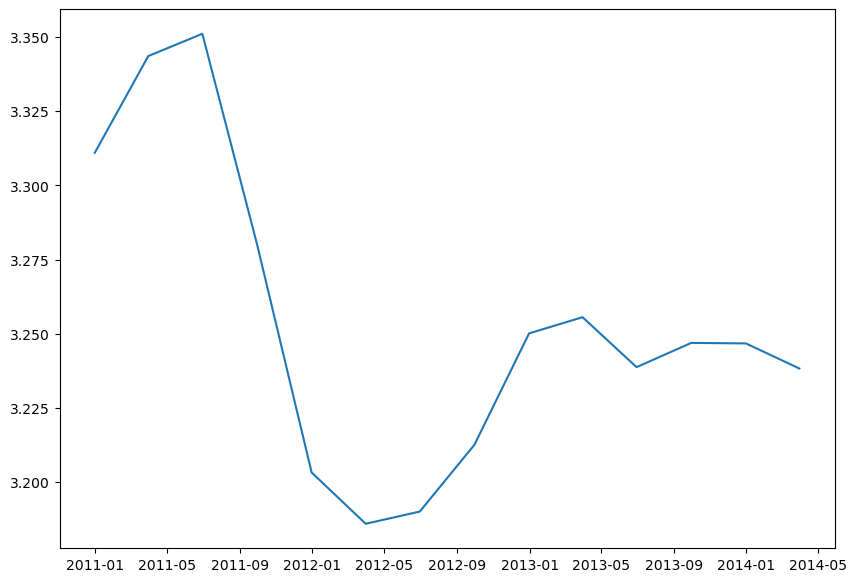

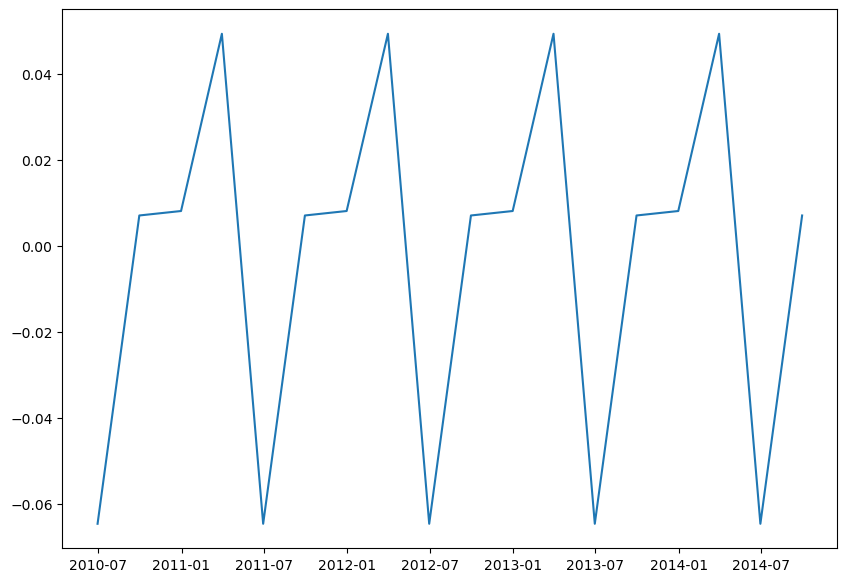

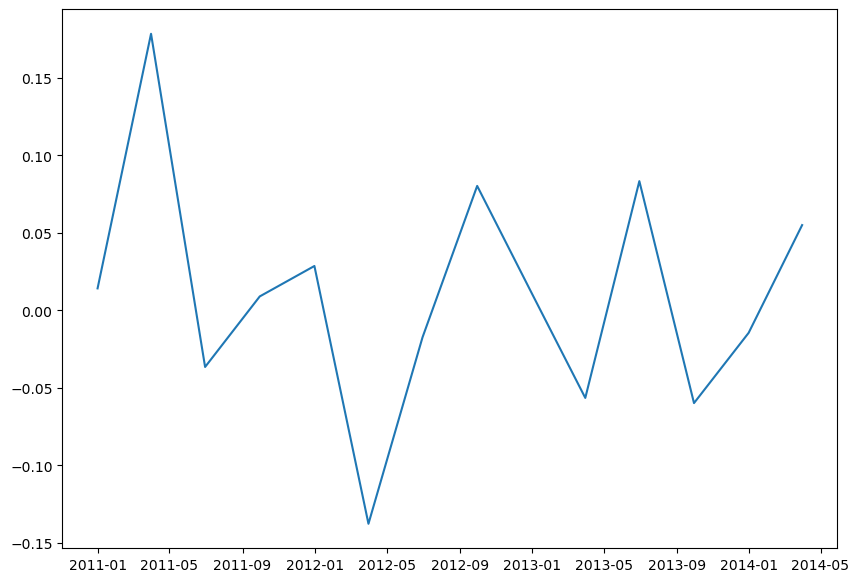

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(d_trend)
plt.figure(figsize=(10,7))
plt.plot(d_seasonality)
plt.figure(figsize=(10,7))
plt.plot(d_residual)
plt.show()

We can see from the above cahrts that the data has all 3 components trend seasonality and noise

### Checking Stationarity

In [ ]:
df = df['sentiment']

In [ ]:
# dickey-fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
def checkStationarity(df):
    pvalue = adfuller(df)[1]
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)
checkStationarity(df)

'p-value=0.20668652786926128. Data is not stationary'

According to Adfuller data is not stationary and thus needs to be differenced

In [ ]:
df=df.rolling(window=2).mean()          
df.dropna(inplace=True)

# Using Autoarima to find optimal parameters 

In [ ]:
from pmdarima.arima import auto_arima
df_new = auto_arima(df,start_p=0,max_p=2, start_q=0,max_q=2, seasonal=True, trace=True)
print(df_new.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-32.301, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-34.193, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=90.321, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-38.593, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-41.095, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-39.591, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-41.434, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 0.860 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   17
Model:               SAR

Auto arima gives us an optimal p,d,q values of (0,1,0) value

# Building sarima model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [ ]:
train = df.iloc[:15]
test = df.iloc[15:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 15, test = 2


In [ ]:
import statsmodels.api

In [ ]:
p=1; d=0; q=2
model = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(1,d,q,4)).fit()
print(model.summary())

C:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                         sentiment   No. Observations:                   15
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 4)   Log Likelihood                  16.636
Date:                           Tue, 03 Jan 2023   AIC                            -19.273
Time:                                   12:01:40   BIC                            -14.316
Sample:                               09-30-2010   HQIC                           -19.326
                                    - 03-31-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.016     64.428      0.000       0.969       1.030
ma.L1          0.0808     94.509      0.001

In [ ]:
start = len(train)
stop = len(train)+len(test)-1

In [ ]:
predictions = model.predict(start,stop,dynamic=True)
print( predictions)

2014-06-30    3.265058
2014-09-30    3.227935
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [ ]:
df_res = pd.DataFrame({'actual':df[9:],'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
df_res.dropna(inplace=True)
print(df_res)

              actual  predicted       err
2014-06-30  3.252281   3.265058 -0.012777
2014-09-30  3.192063   3.227935 -0.035871


In [ ]:
msg = 'ARMA Model. Order=(' + str(0) + ',' + str(0) + ')'
mse1 = mean_squared_error(test,predictions )
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(0,0)
	MSE = 0.0007250050314350817
	RMSE = 0.02692591746691432


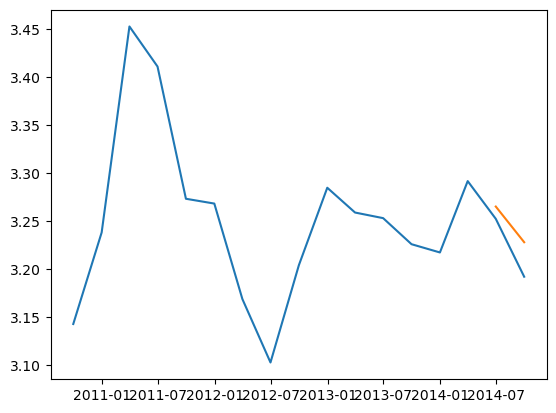

In [ ]:
plt.plot(df)
plt.plot(predictions)

We can see that the sarima model closely follows the data trend

# Prediction for trends after 2014

In [ ]:
model = sm.tsa.statespace.SARIMAX(df,order=(p,d,q),seasonal_order=(1,d,q,4)).fit()

C:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast=model.forecast(10)

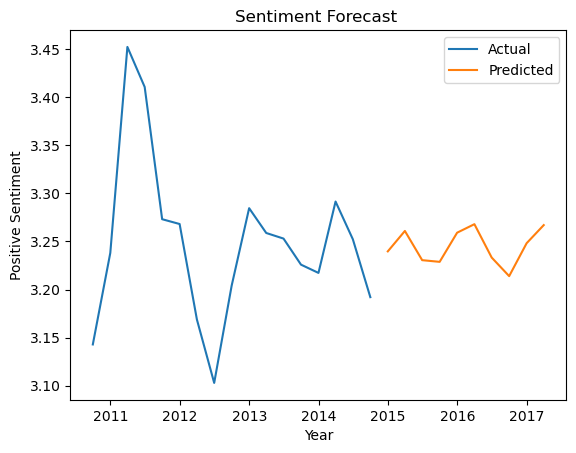

In [ ]:
plt.title("Sentiment Forecast ")
plt.plot(df)
plt.xlabel("Year")
plt.ylabel("Positive Sentiment")
plt.plot(forecast)
plt.legend(['Actual','Predicted'])
plt.show()
